# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
* Idea

# Libraries

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import argparse
import yaml

import DataProcessing.dataset as dataset
import DataProcessing.model_files as model_files
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)
parser.add_argument('--noise', type=float, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")
       
if file_name is None:
    args = parser.parse_args("")
    args.train_model = True
    args.cache = True
    #args.save = True
    args.save = True
    args.sigmoid = False
    args.focal = True
else:    
    args = parser.parse_args()

Jupyter Notebook


# Options

In [3]:
# Generall Parameters
TRAIN_MODEL = True #args.train_model
SEED = None

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
# focal_loss = args.focal
focal_loss = True

beta_upper = 0.5 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma = 2.0 if args.gamma is None else args.gamma
alpha = 2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta = True

config_path = os.path.join(os.getcwd(), 'configs')
model_config_path = os.path.join(config_path, 'model.yaml')

with open(model_config_path, 'r') as file:
    model_cfg = yaml.safe_load(file)

# Load Dataset, Preprocess Images and Dataset

In [4]:
tf.random.set_seed(SEED)

DP = dataset.DataProcessing(model_cfg["INPUT_SHAPE"], model_cfg["OUTPUT_SHAPE"], config_path)
DP.path_definitions()

MF = model_files.ModelFiles()
MF.path_definitions(model_cfg["NAME"], DP.dataset["NAME"], make_dirs=True)
MF.clean_model_directories(model_cfg["CALLBACKS"]["DEL_OLD_CKPT"], model_cfg["CALLBACKS"]["DEL_OLD_TB"])

if TRAIN_MODEL:
    rng = tf.random.Generator.from_seed(123, alg='philox')

    train_ds, img_count_train = DP.load_dataset(DP.key.train)
    train_ds = DP.dataset_processing(train_ds, DP.key.train, shuffle=True, prefetch=True, img_count=int(img_count_train/2),
                                     rng=rng, prior=True)

test_ds, img_count_test = DP.load_dataset(DP.key.test)
test_ds = DP.dataset_processing(test_ds, DP.key.test, shuffle=False, prefetch=False, img_count=img_count_test, prior=True)

2022-10-31 16:51:37.675360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:51:37.685954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:51:37.686120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:51:37.686742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

139
The TRAIN DS contains 140 images.
139
The TEST DS contains 140 images.


# Model

2022-10-31 16:51:39.796422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


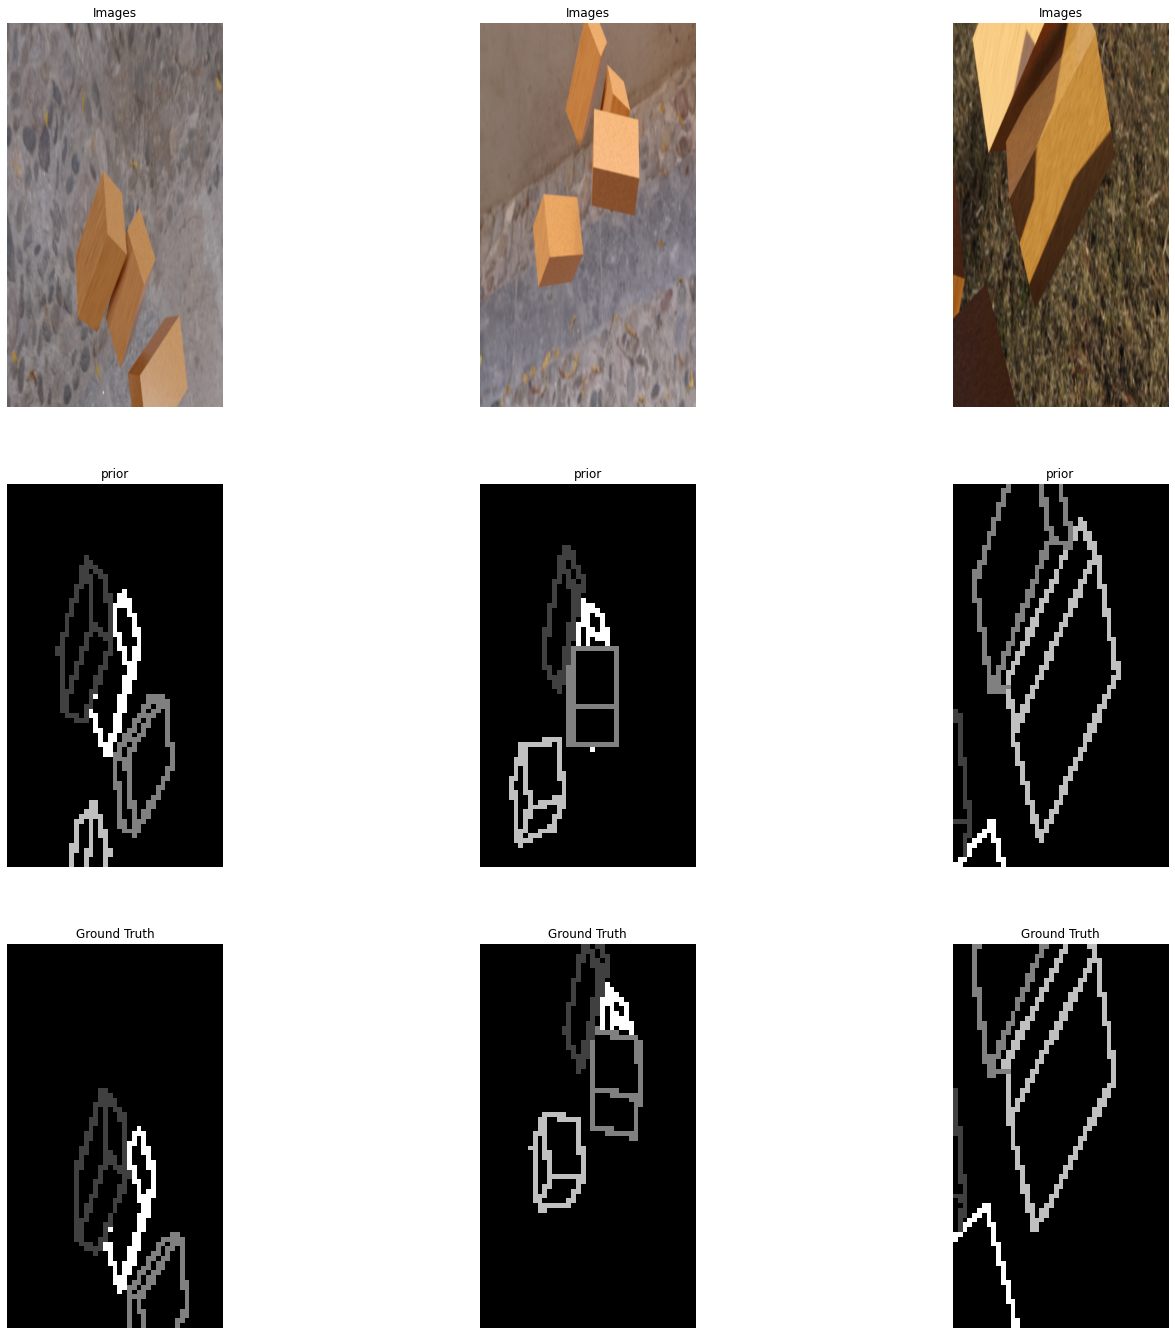

In [5]:
bs = 3
i = 0
for img, label in test_ds.take(1):
    img, label = img, label
    
    plt.figure(figsize=(3 * 8, 24))
    for i in range(bs):
        plt.subplot(3, bs, i + 1)
        plt.title("Images")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0][i, :, :, :]))
        plt.axis('off')
        
        plt.subplot(3, bs, bs + i + 1)
        plt.title("prior")
        plt.imshow(img[1][i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')
        
        plt.subplot(3,bs,2*bs + i + 1)
        plt.title("Ground Truth")
        plt.imshow(label[i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

In [6]:
if TRAIN_MODEL:
    output_dims = model_cfg["OUTPUT_SHAPE"]

    # BACKBONE
    backbone, output_names = backbones.get_backbone(name=model_cfg["BACKBONE"]["NAME"],
                                                    weights=model_cfg["BACKBONE"]["WEIGHTS"],
                                                    height=model_cfg["INPUT_SHAPE"][0],
                                                    width=model_cfg["INPUT_SHAPE"][1],
                                                    alpha=model_cfg["BACKBONE"]["ALPHA"],
                                                    output_layer=model_cfg["BACKBONE"]["OUTPUT_IDS"],
                                                    trainable_idx=model_cfg["BACKBONE"]["TRAIN_IDX"])
    
    # prior edge map input
    input_model = tf.keras.Input(shape=(output_dims[0], output_dims[1],1))
    x = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same",
                      strides=1, use_bias=False)(input_model)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=5, dilation_rate=1, padding="same",
                                        strides=2, use_bias=False)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x_out = tf.keras.layers.ReLU(name="x_out")(x)
    
    # backbone output
    b = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", 
                               strides=2, use_bias=False)(backbone.output[-1])
    b = tf.keras.layers.BatchNormalization()(b)
    b = tf.keras.layers.ReLU()(b)
    
    # Mix layers
    #concat:
    c = tf.keras.layers.Concatenate(axis=-1)([x_out,b])
    c = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same",
                                    strides=1, use_bias=False)(c)
    c = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.ReLU()(c)
    c = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same",
                                strides=1, use_bias=False)(c)
    c = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.ReLU()(c)
    
    # mult. layers:
    mu = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same", 
                           strides=1, use_bias=False)(backbone.output[-1])
    mu = tf.keras.layers.BatchNormalization()(mu)
    mu = tf.keras.layers.ReLU()(mu)
    
    mu = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", 
                       strides=2, use_bias=False)(mu)
    mu = tf.keras.layers.BatchNormalization()(mu)
    mu = tf.keras.layers.ReLU(name="out_mu")(mu)
    
    out = []
    for i in range(9):
        out.append(mu*c[:,:,:,i:i+1])
    x = tf.keras.layers.Concatenate(axis=-1)(out)
    
    # Post Processing
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, dilation_rate=1, padding="same",
                                        strides=2, use_bias=False)(x)
    
    x = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
                               strides=1, use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)    
    
    #x = tf.keras.layers.SeparableConv2D(32, kernel_size=3, dilation_rate=1, padding="same",
    #              strides=1, use_bias=True)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.ReLU()(x)
    #
    
    x_resize = tf.image.resize(x, (output_dims[0], output_dims[1]))
    
    #x = tf.keras.layers.ReLU()(x)
    
    #b1 = tf.keras.layers.Conv2D(4, kernel_size=3, dilation_rate=1, padding="same",
    #                      strides=1, use_bias=True)(backbone.output[0])
    #b1 = tf.keras.layers.BatchNormalization()(b1)
    #b1 = tf.keras.layers.ReLU()(b1)

    #b3 = tf.keras.layers.Conv2D(DP.num_classes, kernel_size=3, dilation_rate=1, padding="same",
    #                      strides=1, use_bias=True)(backbone.output[2])
    #b3 = tf.keras.layers.BatchNormalization()(b3)
    #b3 = tf.keras.layers.ReLU()(b3)

    

    # DASPP
    #daspp = features.DASPP_dilation(backbone.output[-1])

    # Decoder
    #decoded = features.decoder(daspp, backbone.output[-1], output_dims=output_dims, NUM_CLASSES=DP.num_classes,
    #                           num_side_filters=6)

    # TODO: adaptive weight fusion ?
    # CONCATENATE
    #side_outputs = [upsample_side_1, upsample_side_2, decoded]
    
    # concat = features.shared_concatenation(side_outputs,NUM_CLASSES)
    # output = features.fused_classification(concat,NUM_CLASSES,name="output")
    
    
    #side_outputs = [x,b1]
    #side_outputs = [x,b3]
    
    #x1 = tf.keras.layers.Concatenate(axis=-1)(side_outputs)
    
    x_edge = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
                  strides=1, use_bias=True)(x_resize)
    x_edge = tf.keras.layers.BatchNormalization()(x_edge)
    
    x_edge = tf.keras.layers.ReLU()(x_edge)
    
    x_edge = tf.keras.layers.Conv2D(1, kernel_size=3, dilation_rate=1, padding="same",
                                    strides=1, use_bias=True)(x_edge)
    edge_map = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
                                strides=1, use_bias=True)(backbone.output[2])
    
    edge_map = tf.keras.layers.BatchNormalization()(edge_map)
    
    edge_map = tf.keras.layers.ReLU()(edge_map)
    
    edge_map = tf.keras.layers.Conv2D(1, kernel_size=3, dilation_rate=1, padding="same",
                                strides=1, use_bias=True)(edge_map)
    
    x_edge = tf.keras.layers.Concatenate(axis=-1)([x_edge, edge_map])
    
    output_edge = tf.keras.layers.Conv2D(1, kernel_size=3, dilation_rate=1, padding="same",
                                        strides=1, use_bias=True, name="output_edge")(x_edge)
    
    x_label = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
                                strides=1, use_bias=True)(x_resize)
    
    x_label = tf.keras.layers.BatchNormalization()(x_label)
    
    x_label = tf.keras.layers.ReLU()(x_label)
    
    x_label = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
                  strides=1, use_bias=True)(x_label)
    x_label = tf.keras.layers.BatchNormalization()(x_label)
    
    x_label = tf.keras.layers.ReLU()(x_label)
    
    x_label = tf.keras.layers.Concatenate(axis = -1)([x_label, x_resize])
    
    x_label = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same",
              strides=1, use_bias=True)(x_label)
    x_label = tf.keras.layers.BatchNormalization()(x_label)
    
    x_label = tf.keras.layers.ReLU()(x_label)
    
    output_label = tf.keras.layers.Conv2D(1, kernel_size=3, dilation_rate=1, padding="same",
                        strides=1, use_bias=True, name="output_label")(x_label)
    
    
    model = tf.keras.Model(inputs=(backbone.input, input_model), outputs=(output_edge, output_label))

    # model.layers[-1]._name = "output"
    model.summary()


640
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 80, 45, 1)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 640, 360, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 45, 9)    81          ['input_3[0][0]']        

 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 40, 23, 1)   0           ['re_lu_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 40, 23, 1)   0           ['re_lu_3[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 40, 23, 1)   0           ['re_lu_3[0][0]']                
 icingOpLambda)                                                                                   
          

                                                                                                  
 batch_normalization_11 (BatchN  (None, 80, 45, 16)  64          ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_7 (Conv2D)              (None, 80, 45, 16)   2320        ['tf.image.resize[0][0]']        
                                                                                                  
 conv2d_9 (Conv2D)              (None, 80, 45, 16)   2320        ['base_model[0][2]']             
                                                                                                  
 re_lu_9 (ReLU)                 (None, 80, 45, 16)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 batch_nor

# Compile and Train Model

In [10]:
if TRAIN_MODEL:
    # learning rate schedule
    base_learning_rate = 0.0015
    # end_learning_rate = 0.0005
    end_learning_rate = 0.0001
    decay_step = np.ceil(img_count_train / DP.dataset[DP.key.train]["BATCH_SIZE"]) * model_cfg["EPOCHS"]
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate, decay_steps=decay_step,
                                                                end_learning_rate=end_learning_rate, power=0.9)

    frequency = int(
        np.ceil(img_count_train / DP.dataset[DP.key.train]["BATCH_SIZE"]) * model_cfg["CALLBACKS"]["CKPT_FREQ"]) + 1

    logdir = os.path.join(MF.paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath=MF.paths["CKPT"] + "/ckpt-loss={val_loss:.2f}-epoch={epoch:.2f}-f1={val_f1:.4f}",
        save_weights_only=False, save_best_only=False, monitor="val_f1", verbose=1, save_freq='epoch', period=5),
        tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)]

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss={"output_edge": losses.focal_loss_binary,
                       "output_label": losses.squared_loss},
                  metrics={"output_edge": [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                           metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]},
                  loss_weights={"output_edge": 1.0, "output_label": 3.0})

    history = model.fit(train_ds, epochs=model_cfg["EPOCHS"], validation_data=train_ds, callbacks=callbacks)


Epoch 1/120


2022-10-31 17:00:33.752241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insquared_loss/SelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer


45/47 [===========================>..] - ETA: 0s - loss: 604.7394 - output_edge_loss: 39.8219 - output_label_loss: 188.3058 - output_edge_accuracy_edges: 0.9184 - f1: 0.4269 - precision: 0.2775 - recall: 0.9260

2022-10-31 17:00:36.078565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insquared_loss/SelectV2-1-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 5s 50ms/step - loss: 601.7188 - output_edge_loss: 39.6263 - output_label_loss: 187.3642 - output_edge_accuracy_edges: 0.9188 - f1: 0.4269 - precision: 0.2775 - recall: 0.9258 - val_loss: 651.0352 - val_output_edge_loss: 44.3401 - val_output_label_loss: 202.2317 - val_output_edge_accuracy_edges: 0.9152 - val_f1: 0.4182 - val_precision: 0.2703 - val_recall: 0.9239
Epoch 2/120
47/47 [==============================] - 2s 40ms/step - loss: 603.2307 - output_edge_loss: 39.3315 - output_label_loss: 187.9664 - output_edge_accuracy_edges: 0.9184 - f1: 0.4161 - precision: 0.2696 - recall: 0.9178 - val_loss: 712.3519 - val_output_edge_loss: 49.4113 - val_output_label_loss: 220.9802 - val_output_edge_accuracy_edges: 0.9212 - val_f1: 0.4214 - val_precision: 0.2780 - val_recall: 0.8701
Epoch 3/120
47/47 [==============================] - 2s 40ms/step - loss: 592.8740 - output_edge_loss: 39.3775 - output_label_loss: 184.4989 - output_edge_accuracy_edges: 0.918

47/47 [==============================] - 2s 39ms/step - loss: 542.1852 - output_edge_loss: 37.1393 - output_label_loss: 168.3486 - output_edge_accuracy_edges: 0.9188 - f1: 0.4288 - precision: 0.2791 - recall: 0.9267 - val_loss: 629.4283 - val_output_edge_loss: 50.4426 - val_output_label_loss: 192.9952 - val_output_edge_accuracy_edges: 0.9242 - val_f1: 0.4259 - val_precision: 0.2838 - val_recall: 0.8530
Epoch 18/120
47/47 [==============================] - 2s 39ms/step - loss: 536.3763 - output_edge_loss: 36.8749 - output_label_loss: 166.5005 - output_edge_accuracy_edges: 0.9189 - f1: 0.4277 - precision: 0.2783 - recall: 0.9248 - val_loss: 627.8288 - val_output_edge_loss: 47.0087 - val_output_label_loss: 193.6067 - val_output_edge_accuracy_edges: 0.9240 - val_f1: 0.4290 - val_precision: 0.2851 - val_recall: 0.8656
Epoch 19/120
47/47 [==============================] - 2s 39ms/step - loss: 528.0678 - output_edge_loss: 36.7105 - output_label_loss: 163.7857 - output_edge_accuracy_edges: 0.9

47/47 [==============================] - 2s 43ms/step - loss: 493.3777 - output_edge_loss: 34.0311 - output_label_loss: 153.1156 - output_edge_accuracy_edges: 0.9189 - f1: 0.4263 - precision: 0.2766 - recall: 0.9296 - val_loss: 611.6168 - val_output_edge_loss: 44.3371 - val_output_label_loss: 189.0933 - val_output_edge_accuracy_edges: 0.9170 - val_f1: 0.4207 - val_precision: 0.2732 - val_recall: 0.9139
Epoch 34/120
47/47 [==============================] - 2s 43ms/step - loss: 479.9146 - output_edge_loss: 34.3114 - output_label_loss: 148.5344 - output_edge_accuracy_edges: 0.9189 - f1: 0.4363 - precision: 0.2846 - recall: 0.9355 - val_loss: 864.3754 - val_output_edge_loss: 69.6507 - val_output_label_loss: 264.9083 - val_output_edge_accuracy_edges: 0.9234 - val_f1: 0.4153 - val_precision: 0.2775 - val_recall: 0.8249
Epoch 35/120
46/47 [============================>.] - ETA: 0s - loss: 498.8342 - output_edge_loss: 34.4784 - output_label_loss: 154.7852 - output_edge_accuracy_edges: 0.9189 -

47/47 [==============================] - 2s 39ms/step - loss: 455.2160 - output_edge_loss: 32.6453 - output_label_loss: 140.8569 - output_edge_accuracy_edges: 0.9188 - f1: 0.4350 - precision: 0.2834 - recall: 0.9372 - val_loss: 643.5706 - val_output_edge_loss: 55.9965 - val_output_label_loss: 195.8580 - val_output_edge_accuracy_edges: 0.9254 - val_f1: 0.4258 - val_precision: 0.2853 - val_recall: 0.8387
Epoch 50/120
47/47 [==============================] - ETA: 0s - loss: 497.1874 - output_edge_loss: 32.4291 - output_label_loss: 154.9194 - output_edge_accuracy_edges: 0.9190 - f1: 0.4091 - precision: 0.2618 - recall: 0.9366
Epoch 50: saving model to /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=682.35-epoch=50.00-f1=0.4247
INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=682.35-epoch=50.00-f1=0.4247/assets
47/47 [==============================] - 8s 168ms/step - loss: 497.1874 - output_edge_loss: 32.4291 - output_label_loss: 154

45/47 [===========================>..] - ETA: 0s - loss: 422.6023 - output_edge_loss: 30.4965 - output_label_loss: 130.7019 - output_edge_accuracy_edges: 0.9197 - f1: 0.4460 - precision: 0.2922 - recall: 0.9439
Epoch 65: saving model to /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=468.02-epoch=65.00-f1=0.4334
INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/test/TEST/CKPT/ckpt-loss=468.02-epoch=65.00-f1=0.4334/assets
47/47 [==============================] - 8s 170ms/step - loss: 423.2981 - output_edge_loss: 30.6204 - output_label_loss: 130.8926 - output_edge_accuracy_edges: 0.9192 - f1: 0.4452 - precision: 0.2915 - recall: 0.9436 - val_loss: 468.0245 - val_output_edge_loss: 32.1120 - val_output_label_loss: 145.3042 - val_output_edge_accuracy_edges: 0.9207 - val_f1: 0.4334 - val_precision: 0.2835 - val_recall: 0.9196
Epoch 66/120
47/47 [==============================] - 2s 40ms/step - loss: 422.5272 - output_edge_loss: 30.2110 - output_label_loss: 130

Epoch 81/120
47/47 [==============================] - 2s 40ms/step - loss: 400.9304 - output_edge_loss: 29.4012 - output_label_loss: 123.8430 - output_edge_accuracy_edges: 0.9193 - f1: 0.4143 - precision: 0.2664 - recall: 0.9388 - val_loss: 487.9672 - val_output_edge_loss: 40.5688 - val_output_label_loss: 149.1328 - val_output_edge_accuracy_edges: 0.9242 - val_f1: 0.4347 - val_precision: 0.2882 - val_recall: 0.8842
Epoch 82/120
47/47 [==============================] - 2s 40ms/step - loss: 391.7218 - output_edge_loss: 29.0663 - output_label_loss: 120.8852 - output_edge_accuracy_edges: 0.9192 - f1: 0.4230 - precision: 0.2730 - recall: 0.9400 - val_loss: 497.7234 - val_output_edge_loss: 40.0695 - val_output_label_loss: 152.5513 - val_output_edge_accuracy_edges: 0.9239 - val_f1: 0.4348 - val_precision: 0.2880 - val_recall: 0.8875
Epoch 83/120
47/47 [==============================] - 2s 40ms/step - loss: 392.1152 - output_edge_loss: 28.6017 - output_label_loss: 121.1712 - output_edge_accura

47/47 [==============================] - 2s 41ms/step - loss: 370.0160 - output_edge_loss: 28.0532 - output_label_loss: 113.9876 - output_edge_accuracy_edges: 0.9195 - f1: 0.4255 - precision: 0.2751 - recall: 0.9393 - val_loss: 420.4416 - val_output_edge_loss: 35.5038 - val_output_label_loss: 128.3126 - val_output_edge_accuracy_edges: 0.9237 - val_f1: 0.4371 - val_precision: 0.2888 - val_recall: 0.8982
Epoch 98/120
47/47 [==============================] - 2s 40ms/step - loss: 370.3487 - output_edge_loss: 27.7564 - output_label_loss: 114.1975 - output_edge_accuracy_edges: 0.9193 - f1: 0.4301 - precision: 0.2790 - recall: 0.9394 - val_loss: 392.9551 - val_output_edge_loss: 32.5241 - val_output_label_loss: 120.1437 - val_output_edge_accuracy_edges: 0.9232 - val_f1: 0.4382 - val_precision: 0.2887 - val_recall: 0.9085
Epoch 99/120
47/47 [==============================] - 2s 41ms/step - loss: 368.4904 - output_edge_loss: 27.8384 - output_label_loss: 113.5507 - output_edge_accuracy_edges: 0.9

47/47 [==============================] - 2s 40ms/step - loss: 347.3338 - output_edge_loss: 26.6765 - output_label_loss: 106.8858 - output_edge_accuracy_edges: 0.9197 - f1: 0.4682 - precision: 0.3117 - recall: 0.9438 - val_loss: 344.6730 - val_output_edge_loss: 27.2195 - val_output_label_loss: 105.8178 - val_output_edge_accuracy_edges: 0.9215 - val_f1: 0.4383 - val_precision: 0.2869 - val_recall: 0.9286
Epoch 114/120
47/47 [==============================] - 2s 39ms/step - loss: 349.3771 - output_edge_loss: 26.6294 - output_label_loss: 107.5826 - output_edge_accuracy_edges: 0.9196 - f1: 0.4440 - precision: 0.2900 - recall: 0.9478 - val_loss: 342.5838 - val_output_edge_loss: 26.4177 - val_output_label_loss: 105.3887 - val_output_edge_accuracy_edges: 0.9204 - val_f1: 0.4369 - val_precision: 0.2850 - val_recall: 0.9360
Epoch 115/120
45/47 [===========================>..] - ETA: 0s - loss: 348.0778 - output_edge_loss: 26.5723 - output_label_loss: 107.1685 - output_edge_accuracy_edges: 0.9196

# Plot Results

2022-10-31 16:58:26.627093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


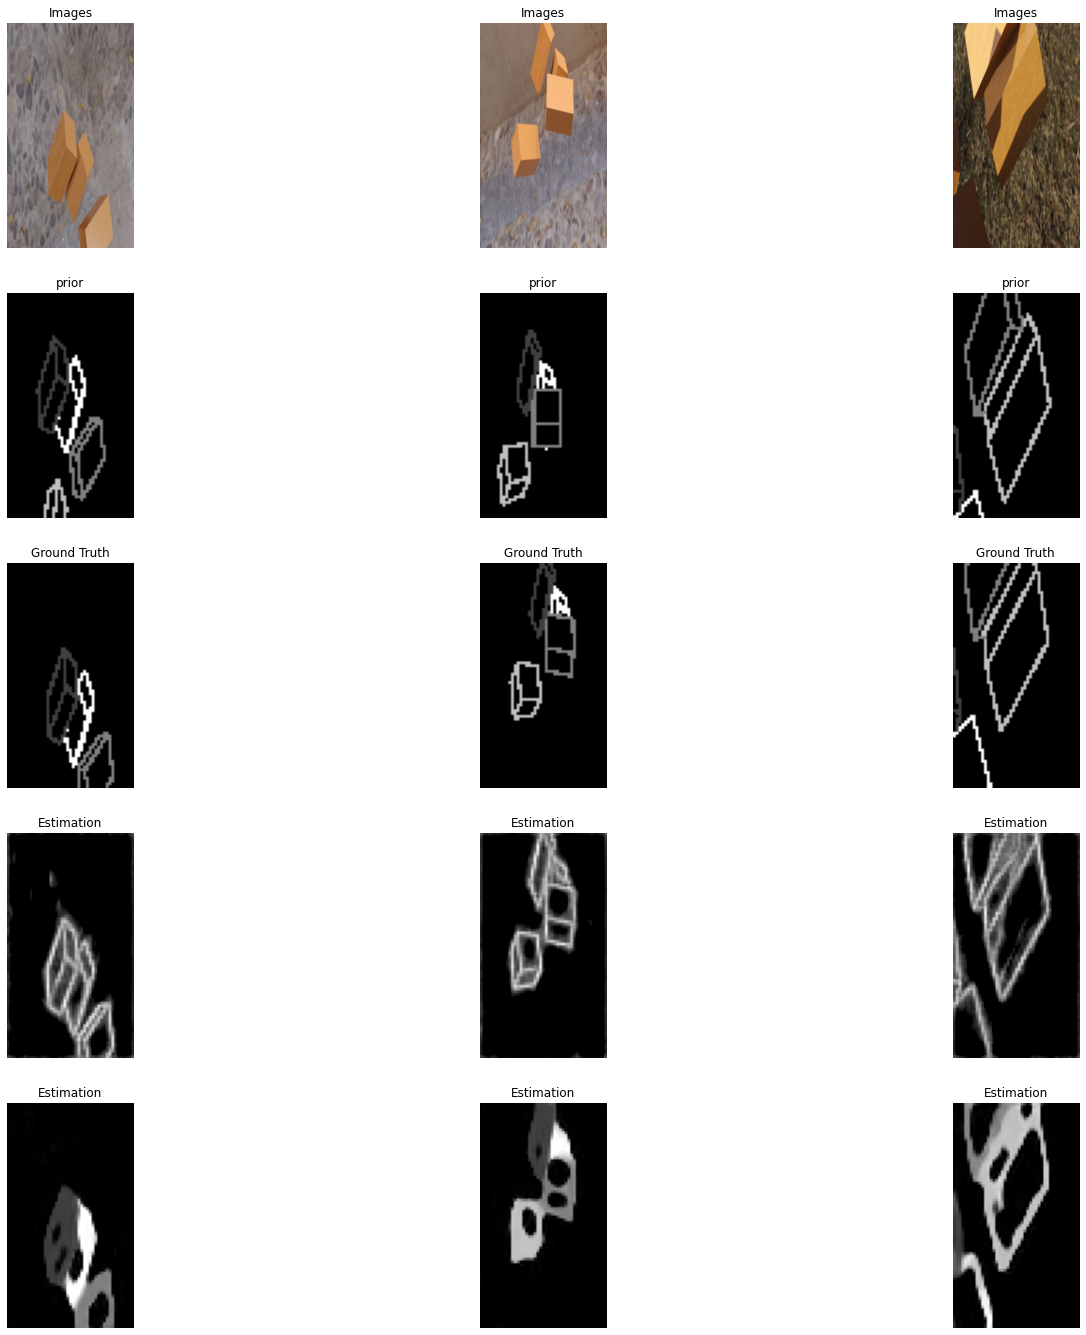

In [8]:
bs = 3
num_graphs = 5
i = 0
for img, label in test_ds.take(1):
    img, label = img, label

    threshold = 0.5

    predictions = model.predict(img)
    
    plt.figure(figsize=(3 * 8, 24))
    for i in range(bs):
        plt.subplot(num_graphs, bs, i + 1)
        plt.title("Images")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0][i, :, :, :]))
        plt.axis('off')
        
        plt.subplot(num_graphs, bs, bs + i + 1)
        plt.title("prior")
        plt.imshow(img[1][i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')
        
        plt.subplot(num_graphs,bs,2*bs + i + 1)
        plt.title("Ground Truth")
        plt.imshow(label[i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')
        
        plt.subplot(num_graphs,bs,3*bs + i + 1)
        plt.title("Estimation")
        plt.imshow(predictions[0][i, :, :, 0], cmap='gray', vmin=-5, vmax=5)
        plt.axis('off')
        
        plt.subplot(num_graphs,bs,4*bs + i + 1)
        plt.title("Estimation")
        plt.imshow(predictions[1][i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

# Fine Tuning

# Evaluate on Test DS of Real Images

## Metrics Evaluation

## Visual Results

# Save Model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={"output_edge": losses.focal_loss_binary,
                   "output_label": losses.squared_loss},
              metrics={"output_edge": [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                       metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]},
              loss_weights={"output_edge": 1.0, "output_label": 3.0})
if model_cfg["SAVE"]:
    model.save(MF.paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges}
    
    model = tf.keras.models.load_model(MF.paths["MODEL"], custom_objects=custom_objects)

NameError: name 'loss' is not defined